# Time Seires Analysis of the S&P 500 Intex Closing Price

time series steps:
    1. plot series
    2. eda
    3. test stationarity
    4. decompose time series
    5. model estimation
    6. Transform Data to Adjust for Non-Stationarity
    7. Test for Stationarity
    8. Build a Model 
    9. Forecast

The S&P 500: https://en.wikipedia.org/wiki/S%26P_500_Index

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

%matplotlib inline

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

%matplotlib inline
plt.rcParams.update(params)

In [2]:
import quandl
import warnings
import itertools


#arima modeling
from arima_utils import ad_fuller_test, plot_rolling_stats
from arima_utils import plot_acf_pacf, arima_gridsearch_cv

In [3]:
import math

# specify to ignore warning messages
warnings.filterwarnings("ignore") 

from lstm_utils import get_raw_data
from lstm_utils import get_seq_model
from lstm_utils import get_seq_train_test
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


## 1. Get Data

We would utilize the pandas_datareader library to get the required S&P 500 index history using Yahoo Finance databases.
For S&P 500 index, the ticker name is ^GSPC. 
The plot for closing price is depicted below.

In [4]:
STOCK_INDEX = '^GSPC'
sp_df = get_raw_data(STOCK_INDEX)
sp_df.head()

,High,Low,Open,Close,Volume,Adj Close
2010-01-04,1133.869995,1116.560059,1116.560059,1132.989990,3.991400e+09,1132.989990
2010-01-05,1136.630005,1129.660034,1132.660034,1136.520020,2.491020e+09,1136.520020
2010-01-06,1139.189941,1133.949951,1135.709961,1137.140015,4.972660e+09,1137.140015
2010-01-07,1142.459961,1131.319946,1136.270020,1141.689941,5.270680e+09,1141.689941
2010-01-08,1145.390015,1136.219971,1140.520020,1144.979980,4.389590e+09,1144.979980


In [5]:
sp_close_series = sp_df.Close 
sp_close_series.head()

2010-01-04    1132.989990
2010-01-05    1136.520020
2010-01-06    1137.140015
2010-01-07    1141.689941
2010-01-08    1144.979980
Freq: D, Name: Close, dtype: float64

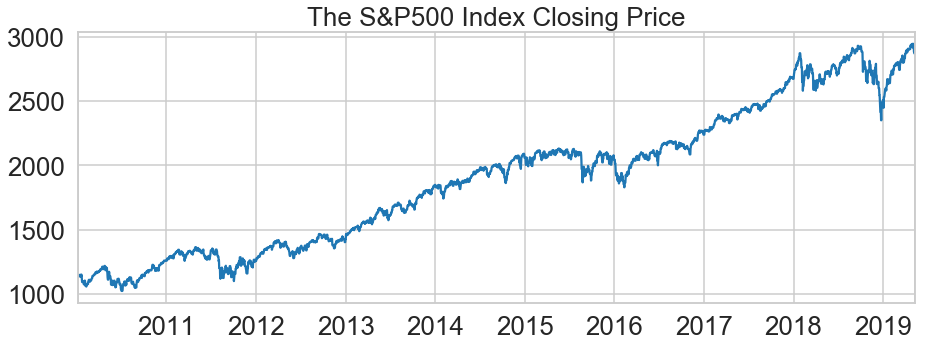

In [6]:
sp_close_series.plot(title = "The S&P500 Index Closing Price")

# ！！！补充differencing

## 2. Time Series Decomposition

Time series decomposition works by splitting a time series into three components: seasonality, trends and random fluctiation.
- Seasonal: Patterns that repeat with a fixed period of time. For example, a website might receive more visits during weekends; this would produce data with a seasonality of 7 days.
- Trend: The underlying trend of the metrics. A website increasing in popularity should show a general trend that goes up.
- Random: Also call “noise”, “irregular” or “remainder,” this is the residuals of the original time series after the seasonal and trend series are removed.

Visualizing our time-series data enables us to make inferences about important components, such as trend, seasonality, heteroskedasticity, and stationarity.

In [7]:
sp_close_df = pd.DataFrame(sp_close_series)
sp_close_df.reset_index(inplace=True)
sp_close_df.head(7)
#sp_close_df1 = sp_close_df.rename(index=str, columns={"index": "datetime"})
#sp_close_df1.head()

,index,Close
0,2010-01-04,1132.989990
1,2010-01-05,1136.520020
2,2010-01-06,1137.140015
3,2010-01-07,1141.689941
4,2010-01-08,1144.979980
5,2010-01-09,1144.979980
6,2010-01-10,1144.979980


The frequency of decomposition must be an interval, which 'may' repeat. So we have data with day-to day frequency and we are looking for a weekly repetition of behavior.
We would like to see every season trend and changing pattern of index closing price.

[5, 22, 65, 261]
Time decomposition: weekly, monthly, quaterly, yearly...


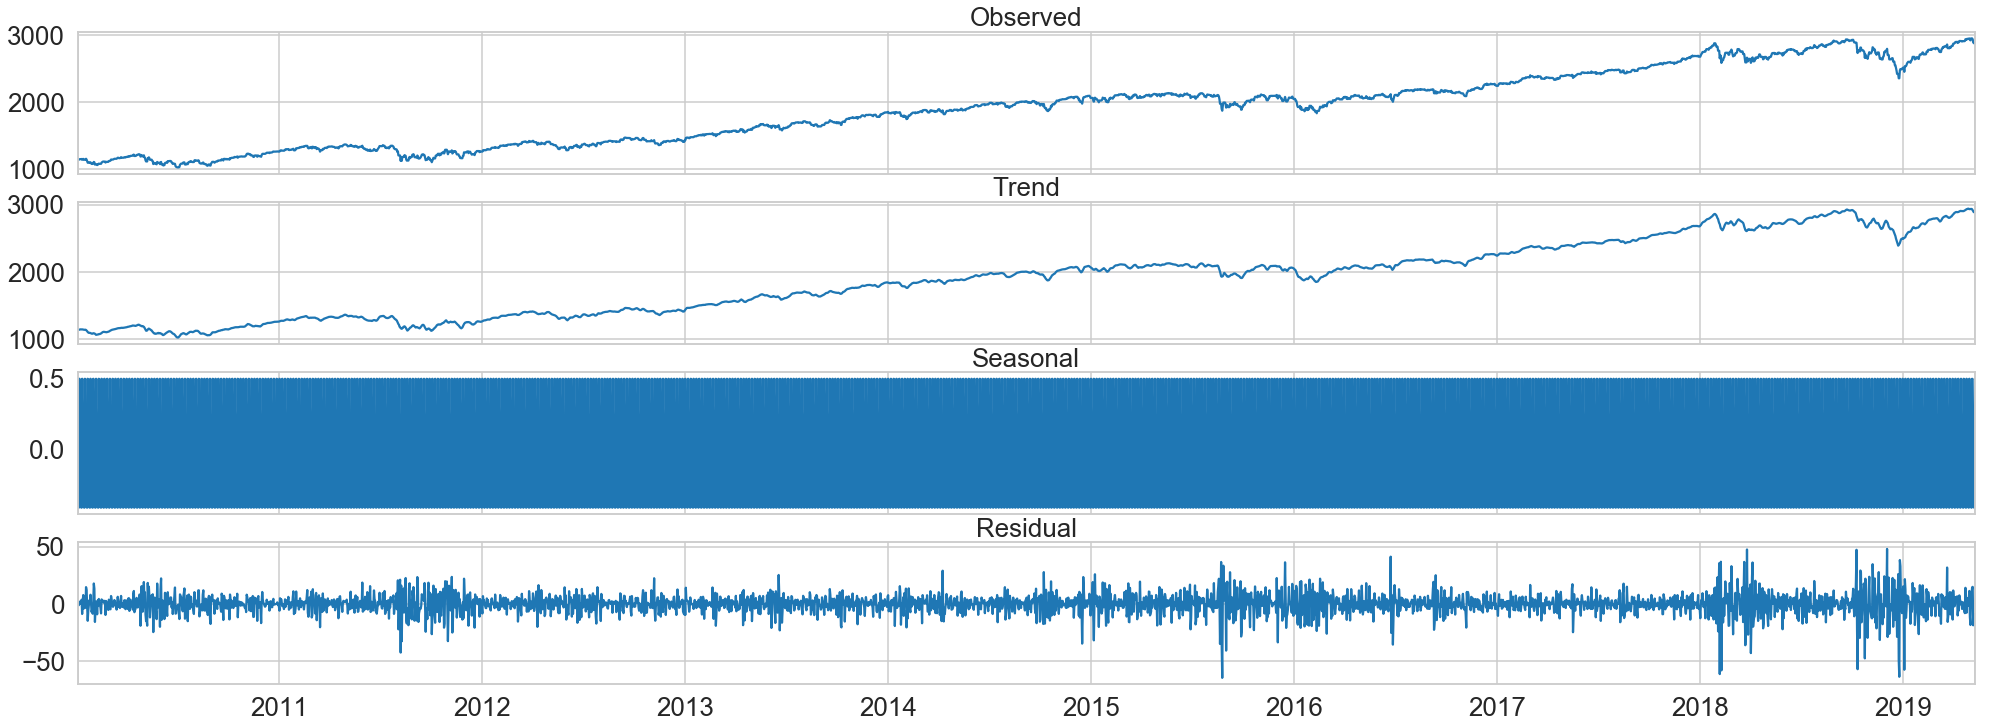

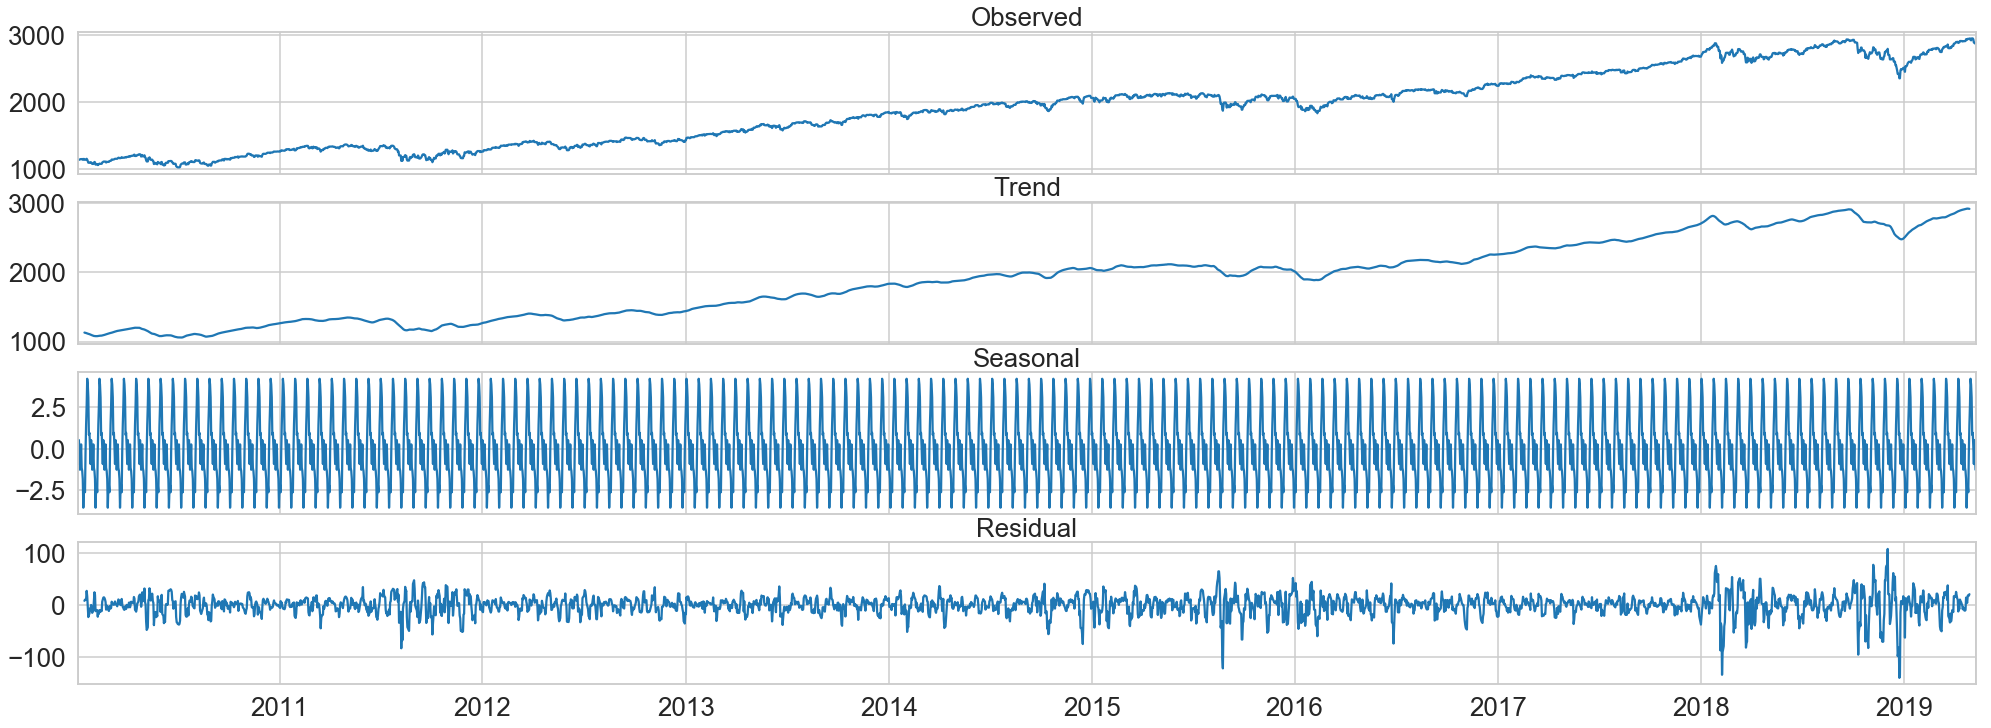

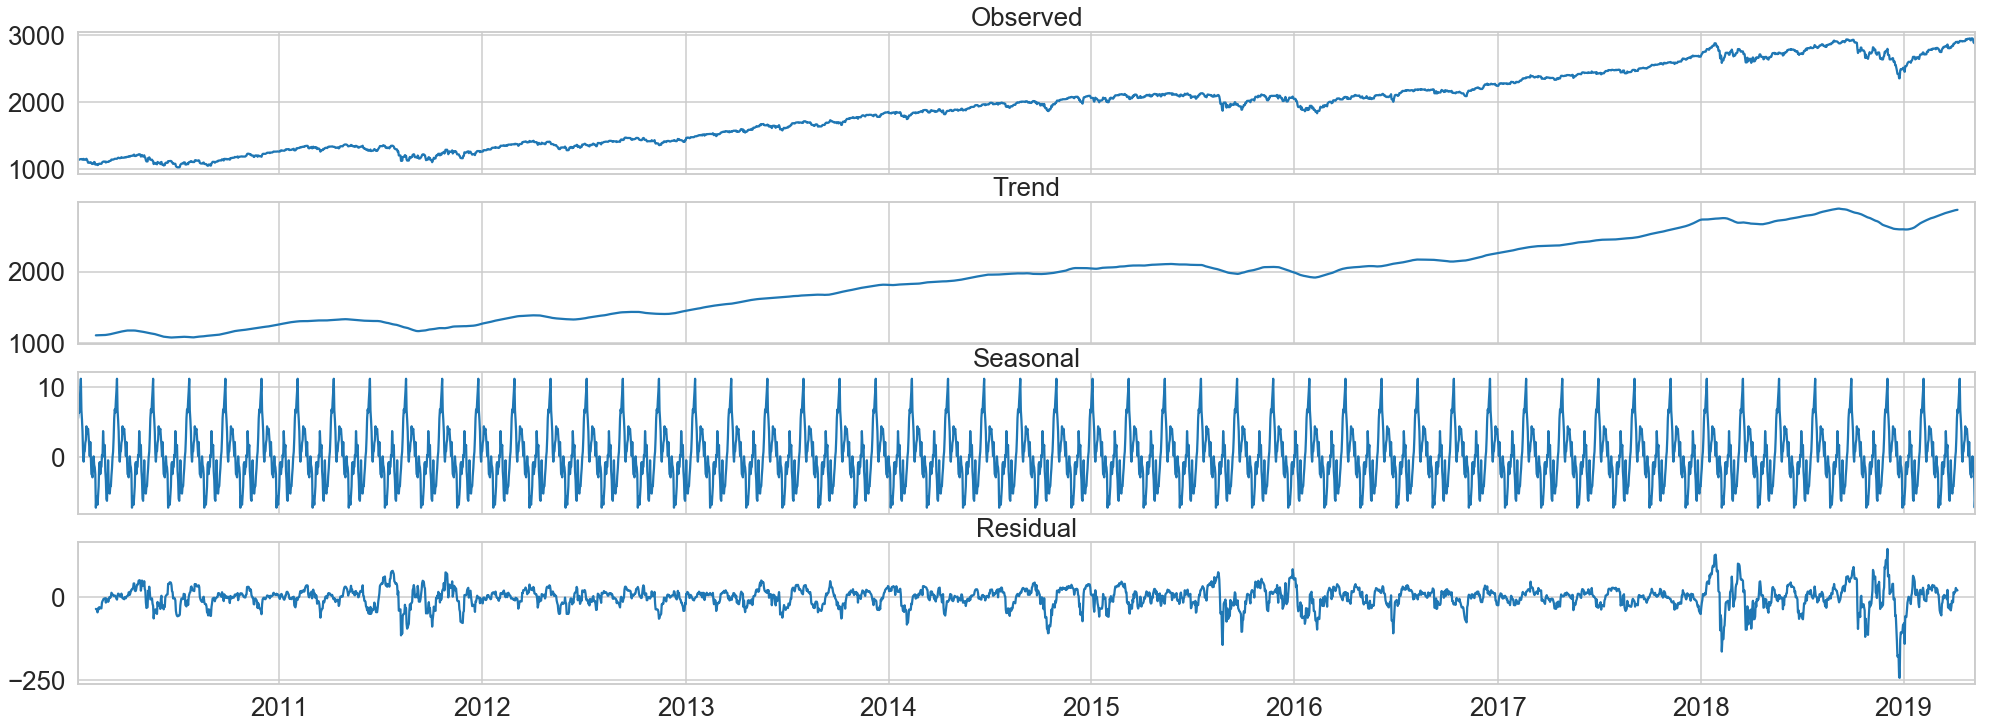

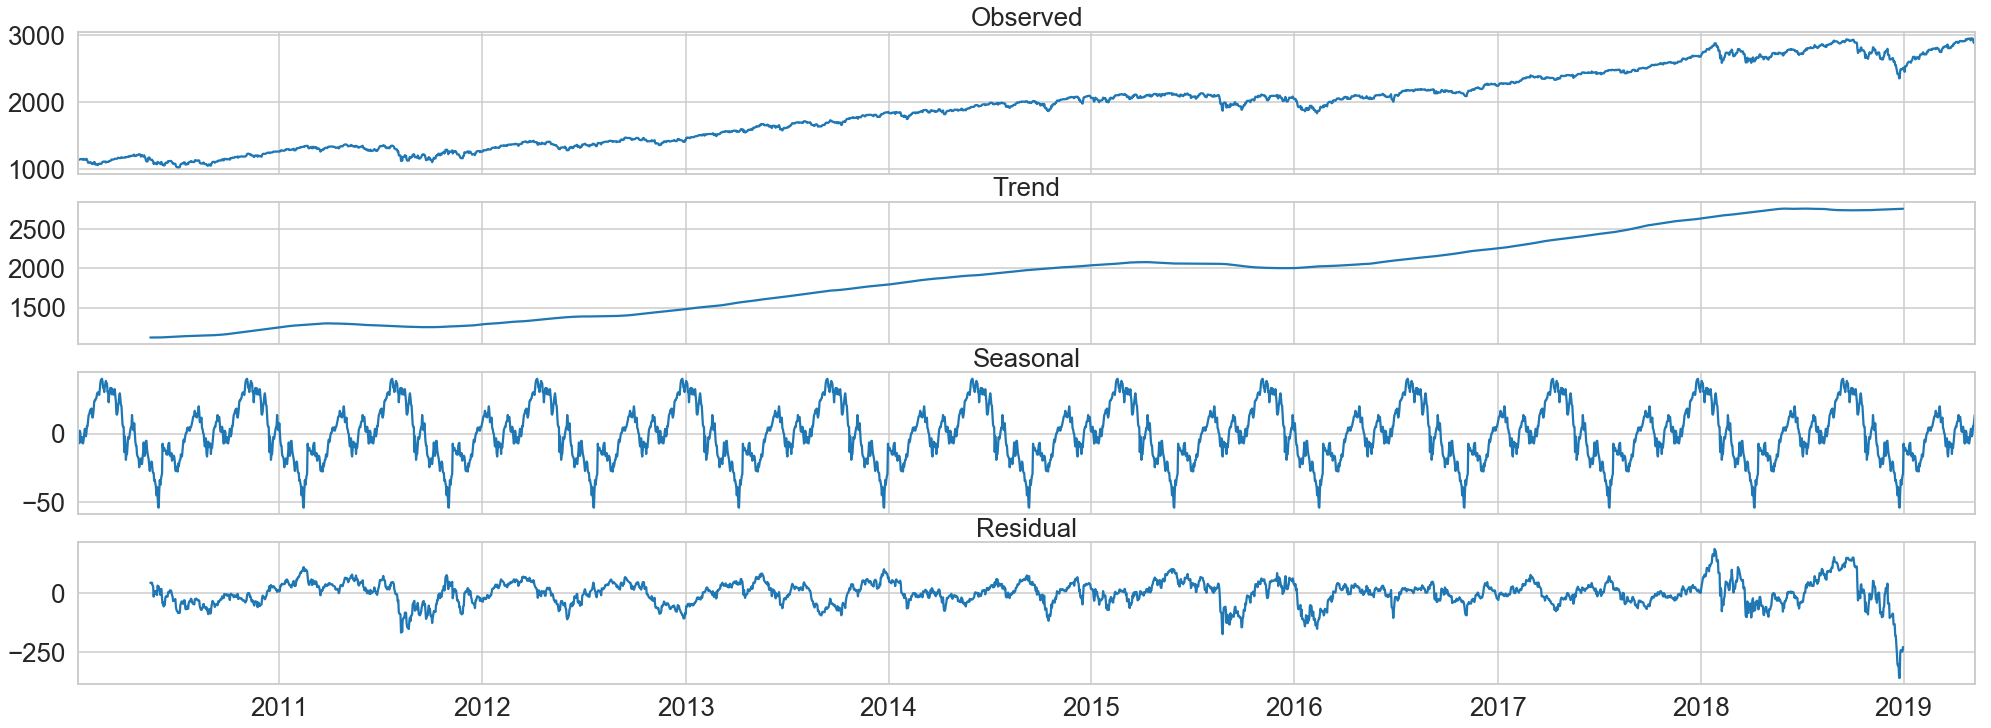

In [8]:
sp_close_df['date_of_transaction'] = pd.to_datetime(sp_close_df['index'])
sp_close_df.head(10)   

trading_days = 365 - 104
week = round(trading_days/52)
month = round(trading_days/12)
quater = round(trading_days/4)
year = trading_days

ts_close = pd.Series(sp_close_df.Close.values,
                    index=pd.date_range(
                                sp_close_df.date_of_transaction.min(),
                                sp_close_df.date_of_transaction.max(),
                                freq='D')
                     )
period_list = [week, month, quater, year]
print(period_list)
print("Time decomposition: weekly, monthly, quaterly, yearly...")

for i in period_list:
    deompose = seasonal_decompose(ts_close.interpolate(), freq = i)
    #deompose.plot()
      
    fig, axs = plt.subplots(4,1, sharex=True, figsize=(34,12))
    deompose.observed.plot(ax=axs[0], title = 'Observed')
    deompose.trend.plot(ax=axs[1], title = 'Trend')
    deompose.seasonal.plot(ax=axs[2], title = 'Seasonal')
    deompose.resid.plot(ax=axs[3], title = 'Residual')

## 3. Simple moving average and exponential smoothing based forecasting¶
     

### Simple Moving Average

moving average: https://en.wikipedia.org/wiki/Moving_average
??? how to select moving average window?

In [9]:
sp_close_df.head(10) 

,index,Close,date_of_transaction
0,2010-01-04,1132.989990,2010-01-04
1,2010-01-05,1136.520020,2010-01-05
2,2010-01-06,1137.140015,2010-01-06
3,2010-01-07,1141.689941,2010-01-07
4,2010-01-08,1144.979980,2010-01-08
5,2010-01-09,1144.979980,2010-01-09
6,2010-01-10,1144.979980,2010-01-10
7,2010-01-11,1146.979980,2010-01-11
8,2010-01-12,1136.219971,2010-01-12
9,2010-01-13,1145.680054,2010-01-13


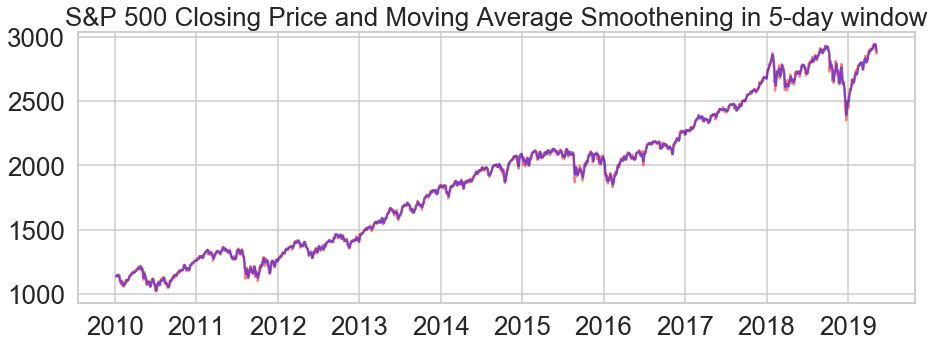

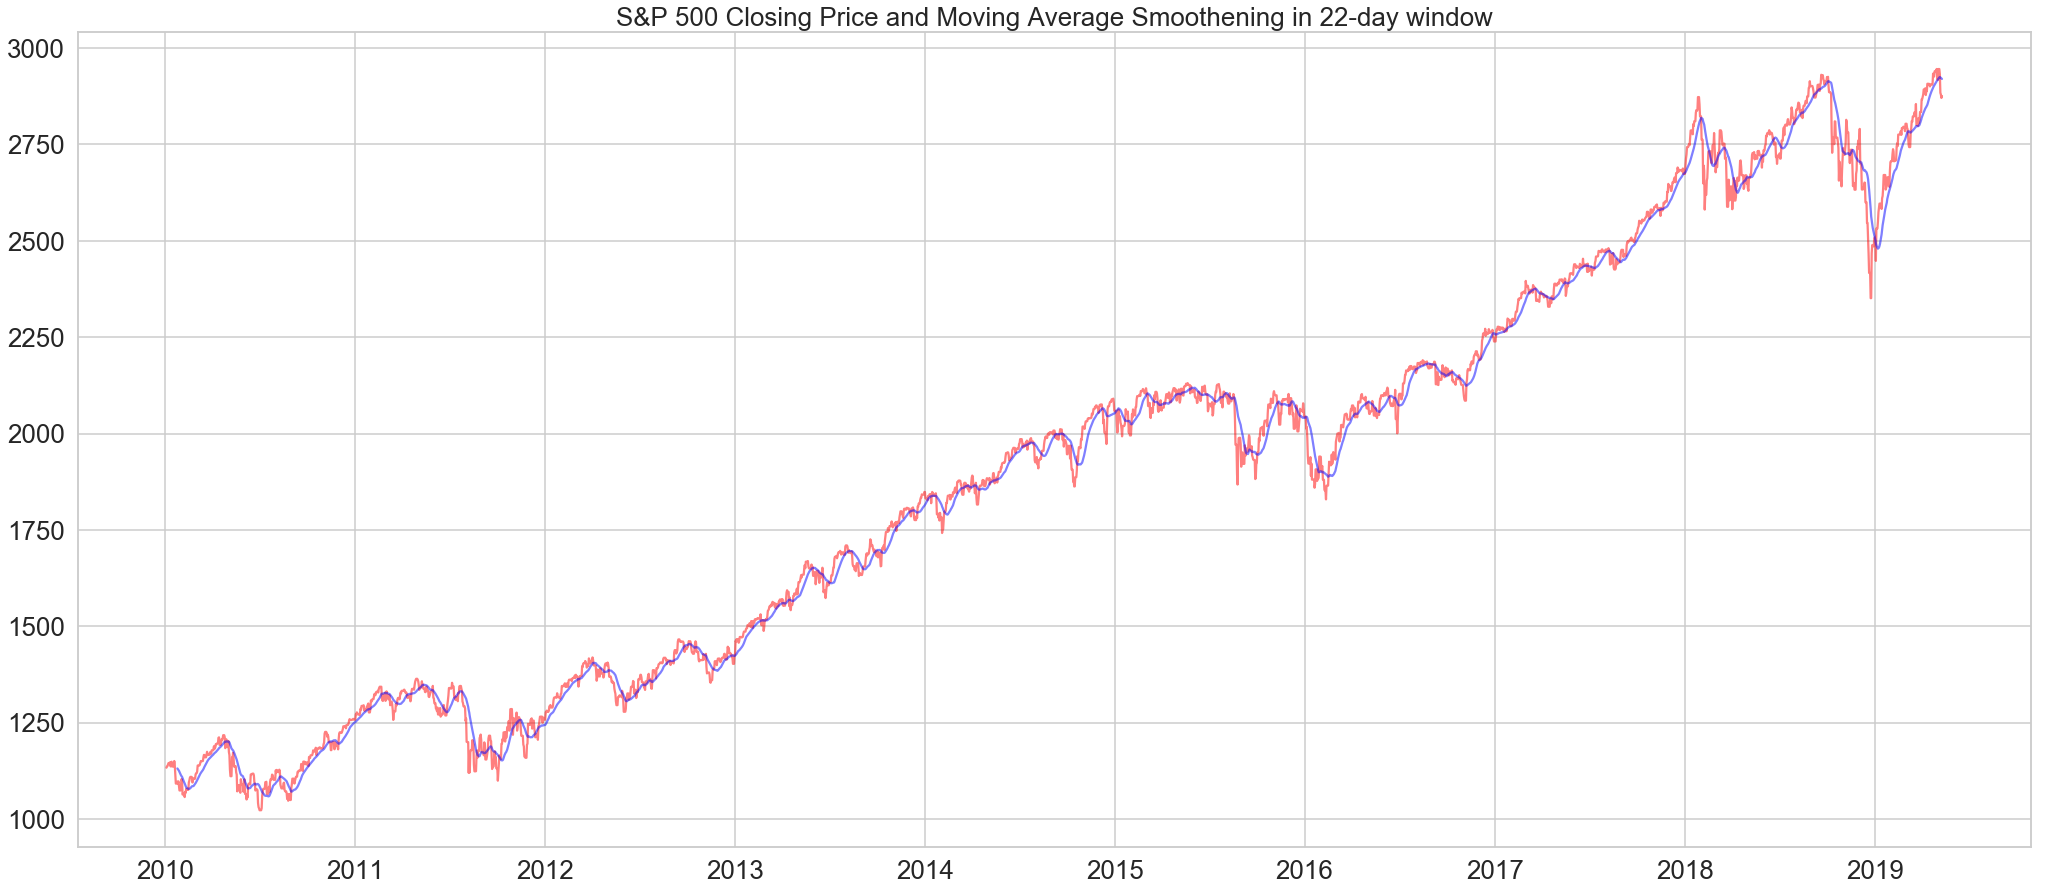

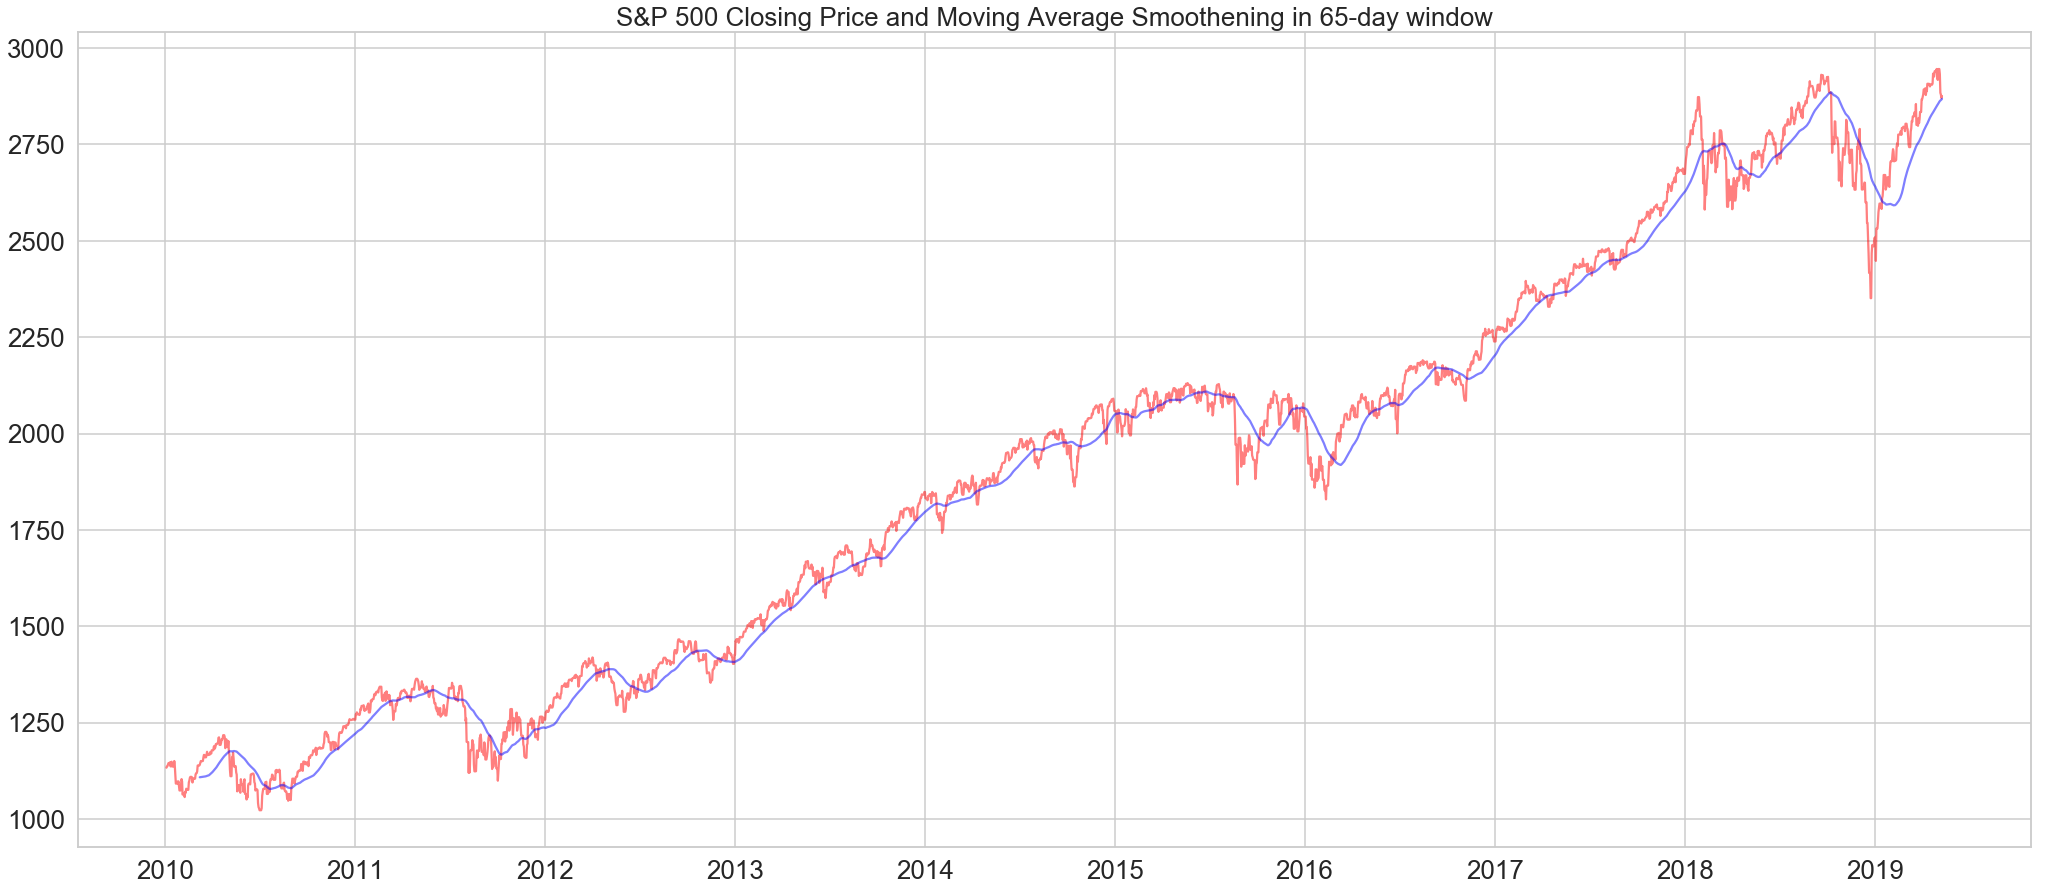

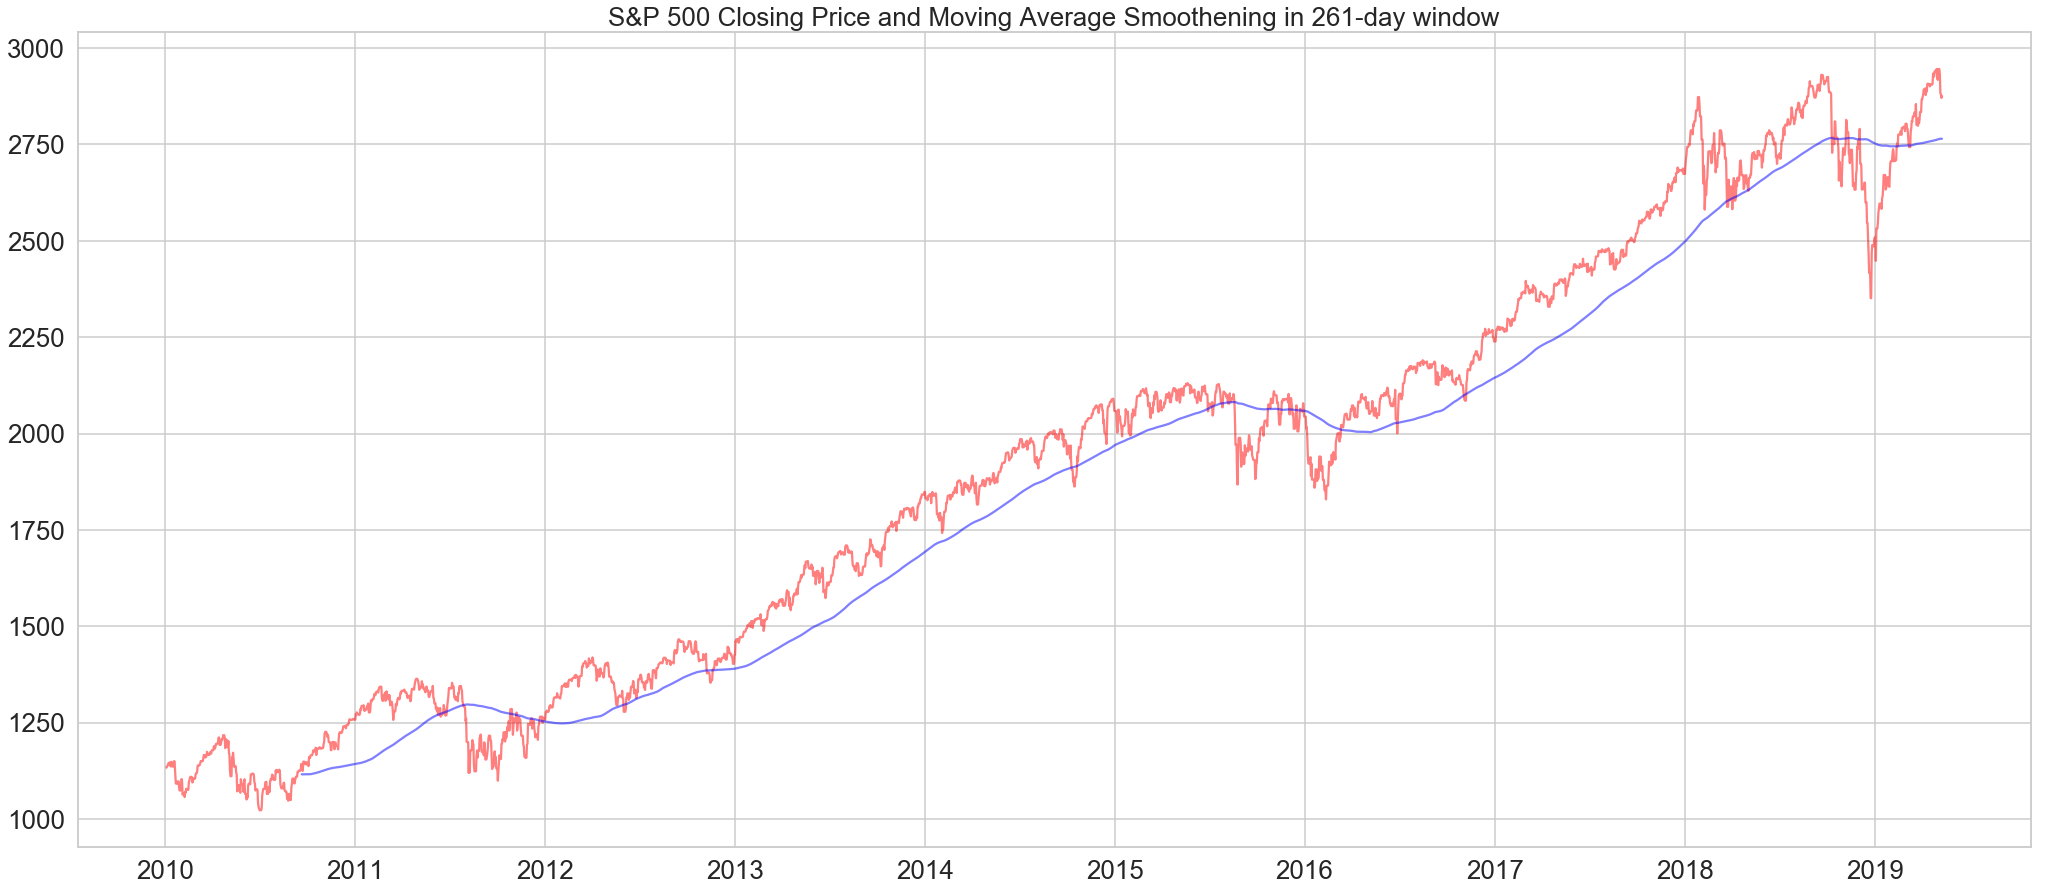

<Figure size 2520x1080 with 0 Axes>

In [10]:
for window in period_list:
    sp_close_df['moving_average'] = sp_close_df['Close'].rolling(window=window,
                                                        center=False).mean()
    #sp_close_df[['Close','moving_average']].head(10)
    #print(sp_close_df.head(5))
    plt.plot(sp_close_df.date_of_transaction, sp_close_df.Close,'-',color='red',alpha=0.5)
    plt.plot(sp_close_df.date_of_transaction, sp_close_df.moving_average, color='b', alpha=0.5)
    plt.title('S&P 500 Closing Price and Moving Average Smoothening in '+ str(window) + '-day window')
    plt.figure(figsize=(35,15))
    #plt.legend()

### Exponential Smoothing¶


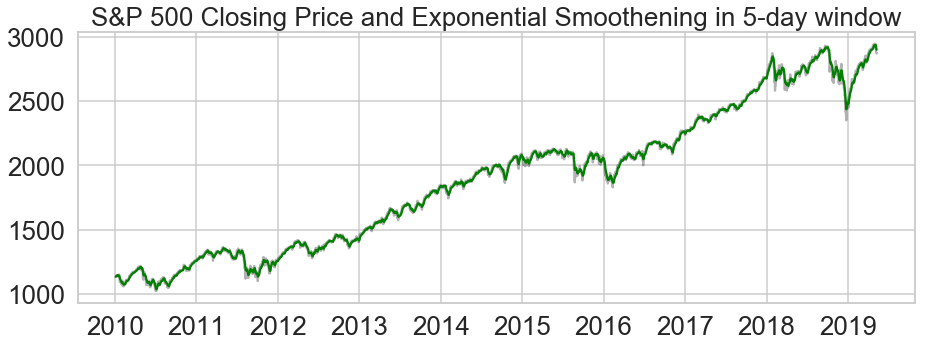

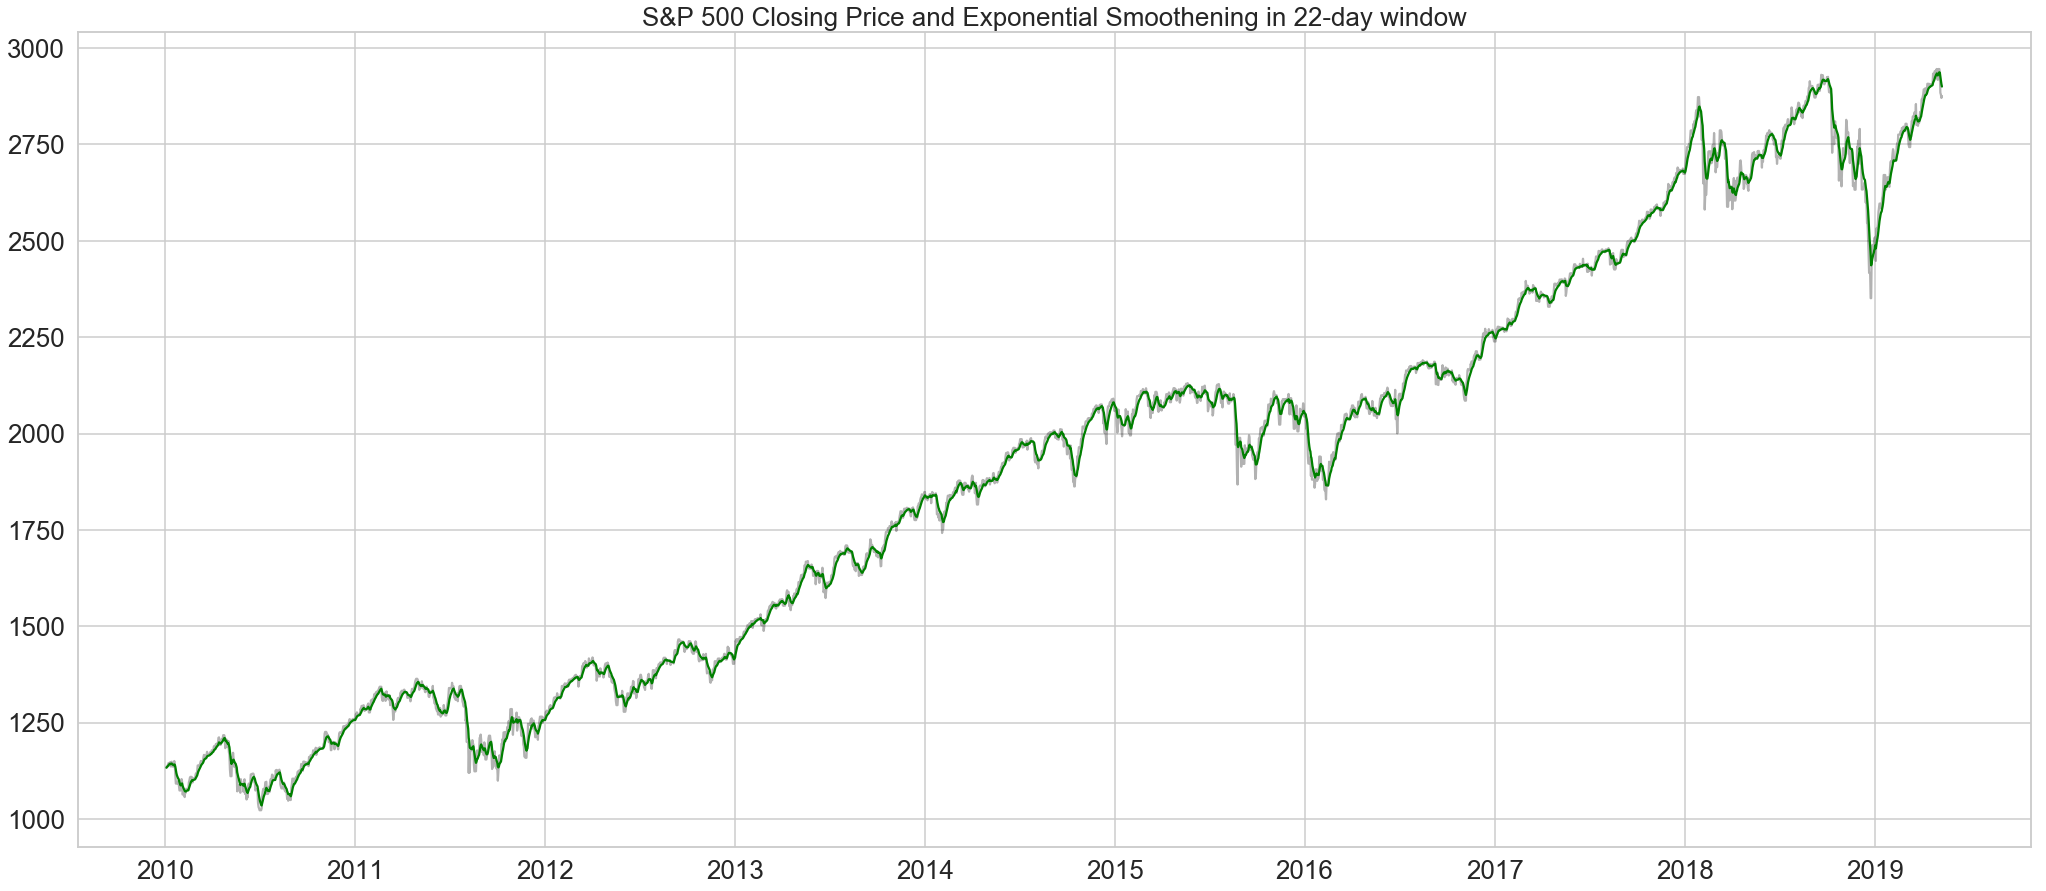

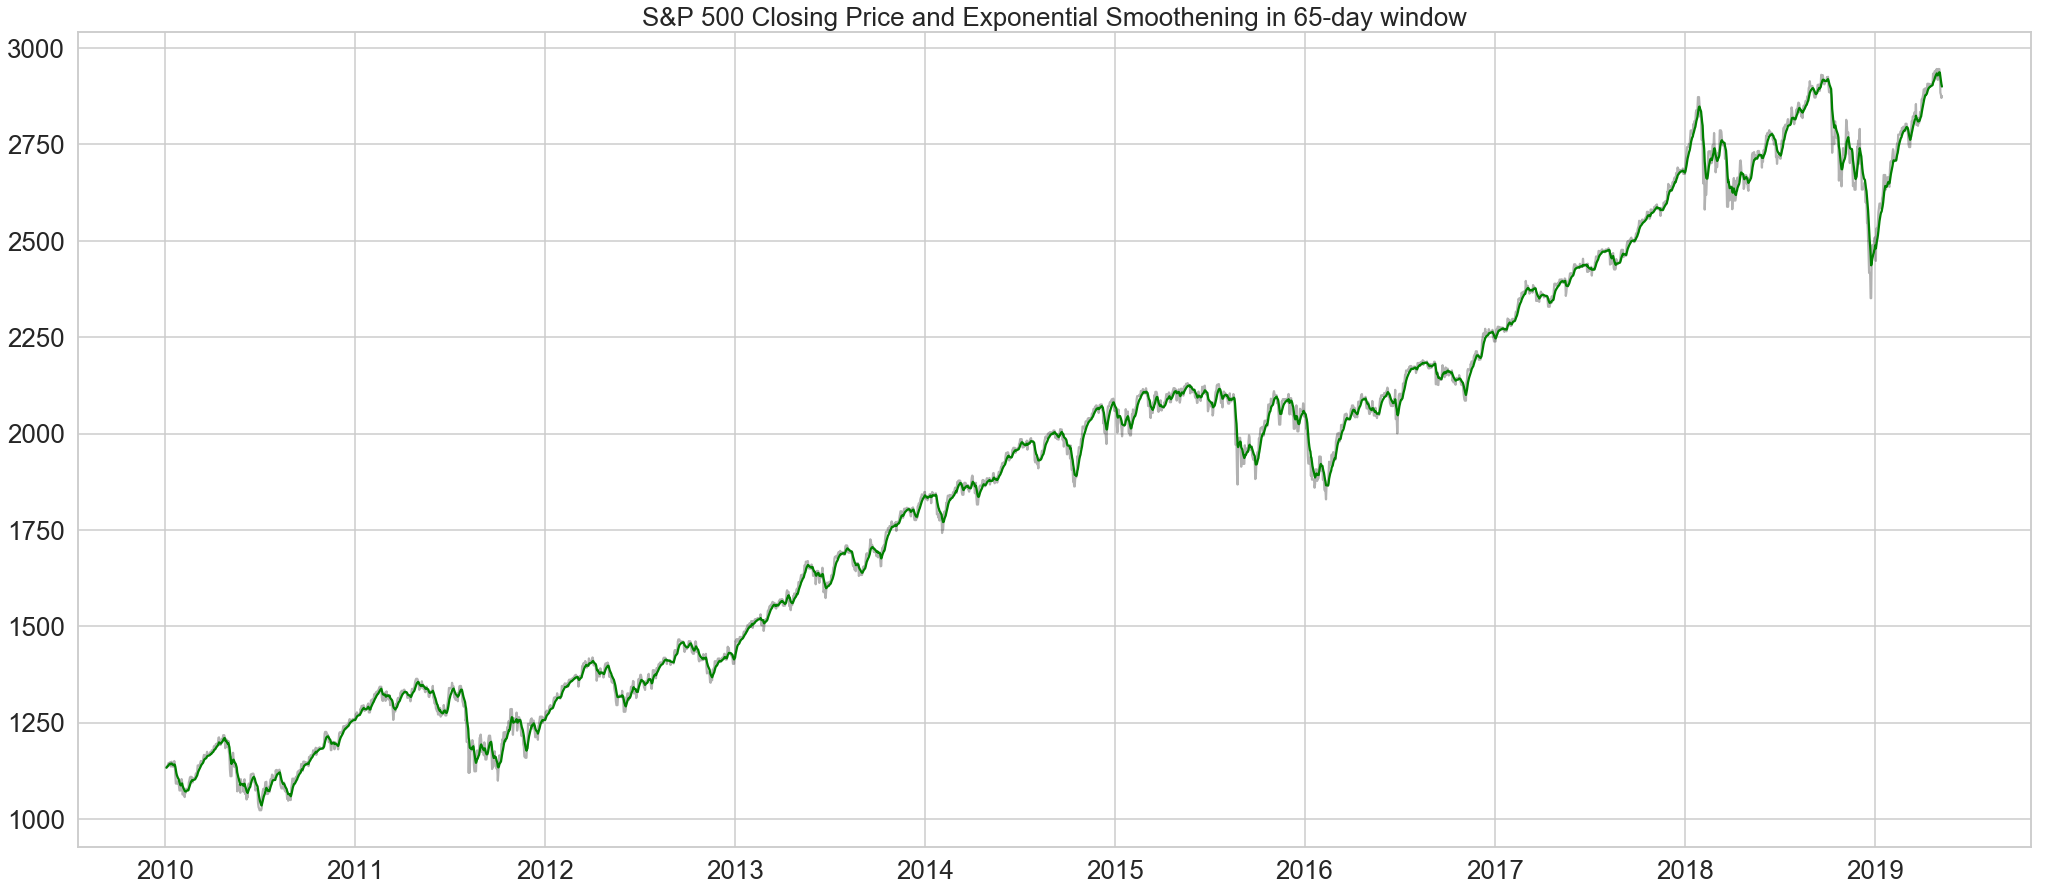

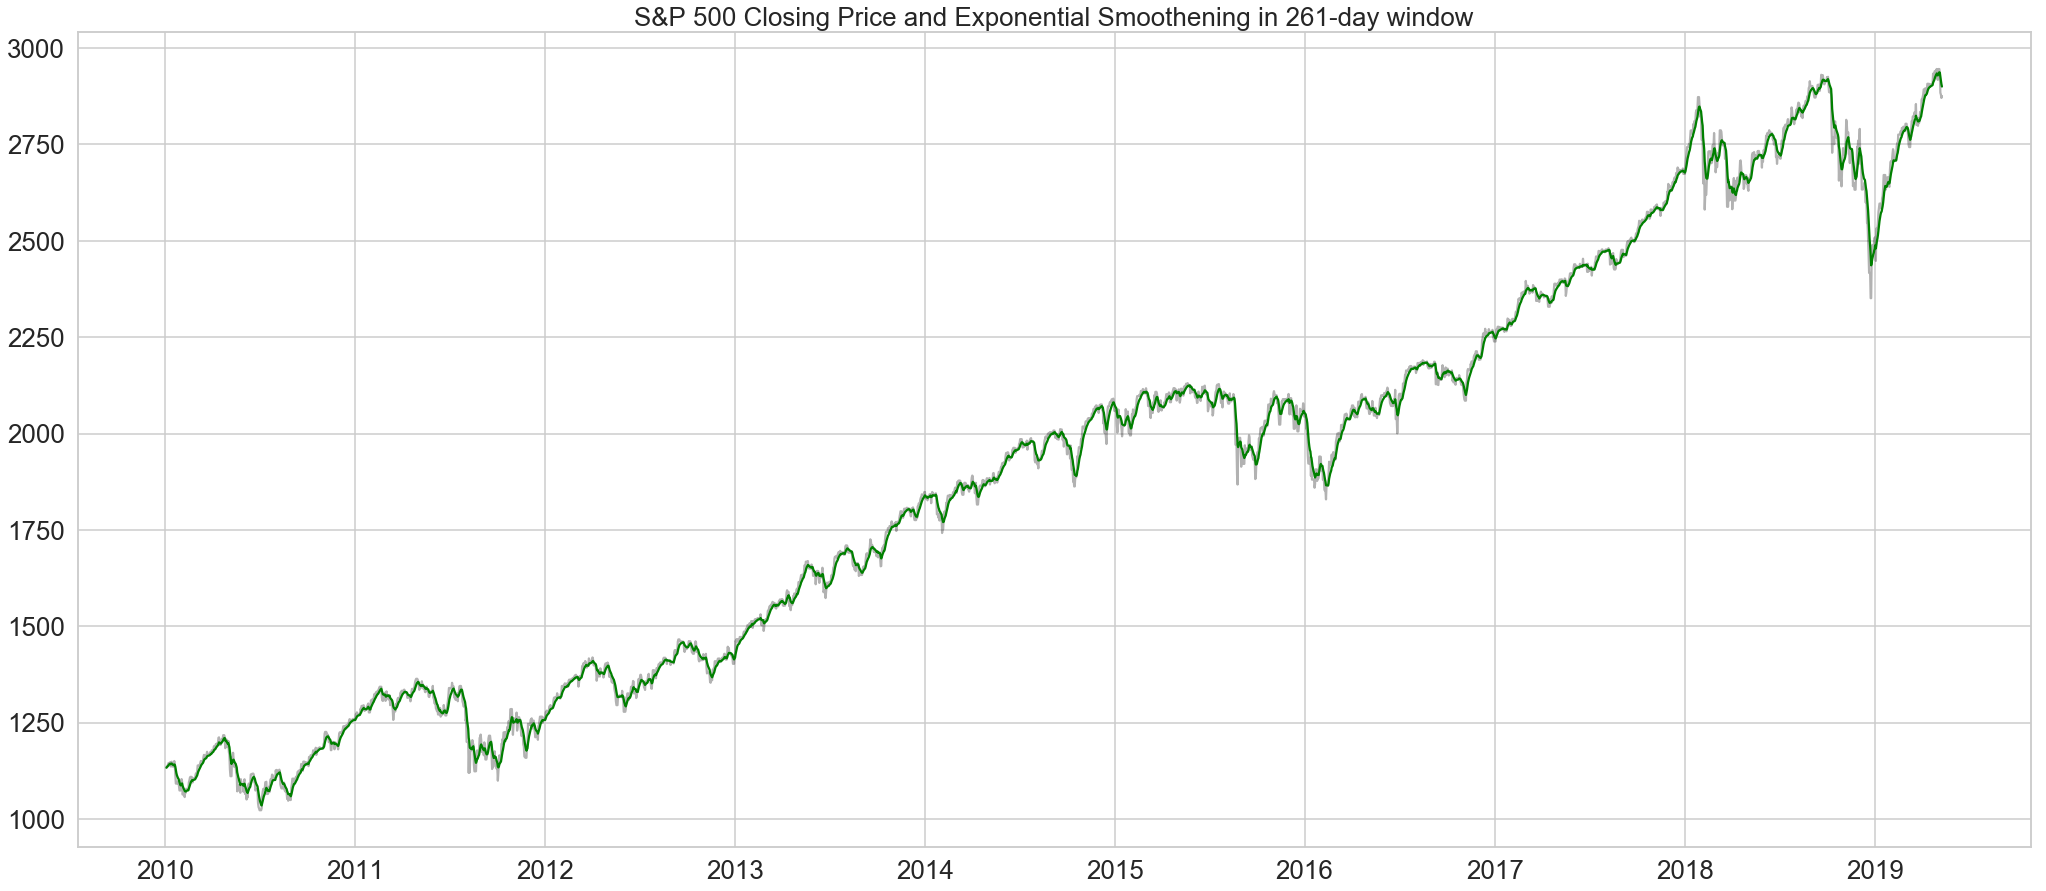

<Figure size 2520x1080 with 0 Axes>

In [11]:
for window in period_list:
    sp_close_df['ewma'] = sp_close_df['Close'].ewm(halflife=3,
                                            ignore_na=False,
                                            min_periods=0,
                                            adjust=True).mean()

    plt.plot(sp_close_df.date_of_transaction, sp_close_df.Close,'-',color='black',alpha=0.3)
    plt.plot(sp_close_df.date_of_transaction, sp_close_df.ewma,color='g')
    plt.title('S&P 500 Closing Price and Exponential Smoothening in '+ str(window) + '-day window')
    plt.figure(figsize=(35,15))

## 4. Test for Stationarity

We are going to make use of Augmented Dickey Fuller test to check the series for stationarity, since stationarity is one of the primary assumptions of ARIMA models.

### Dickey Fuller Test for Stationarity

In [12]:
sp_close_arima = pd.DataFrame(sp_close_series)
sp_close_arima.reset_index(inplace=True)
sp_close_arima.head(7)

,index,Close
0,2010-01-04,1132.989990
1,2010-01-05,1136.520020
2,2010-01-06,1137.140015
3,2010-01-07,1141.689941
4,2010-01-08,1144.979980
5,2010-01-09,1144.979980
6,2010-01-10,1144.979980


Test Statistic                   -0.157373
p-value                           0.943416
#Lags Used                        7.000000
Number of Observations Used    3406.000000
Critical Value (1%)              -3.432271
Critical Value (5%)              -2.862389
Critical Value (10%)             -2.567222
dtype: float64


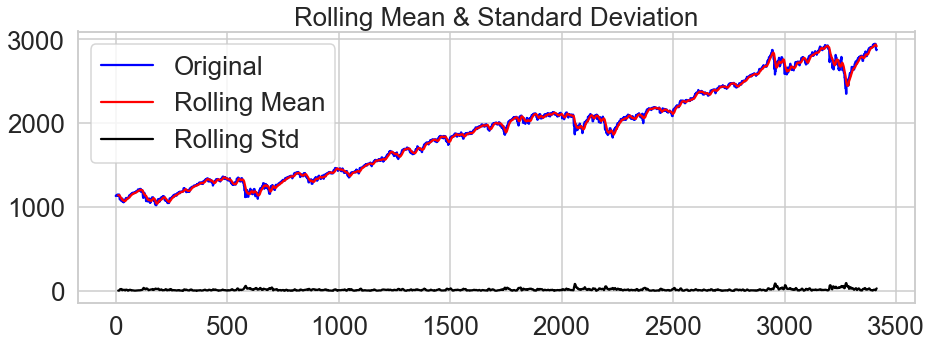

In [13]:
# Original Series
ad_fuller_test(sp_close_arima.Close)
plot_rolling_stats(sp_close_arima.Close)

Result Interpretation:
The test statistic of AD Fuller test (-0.184719) is greater than the critical value(s), hence we fail to reject the null hypothesis. The series data is non-stationary and has a unit root.

### Log Transformation

Test Statistic                   -0.661414
p-value                           0.856493
#Lags Used                        7.000000
Number of Observations Used    3406.000000
Critical Value (1%)              -3.432271
Critical Value (5%)              -2.862389
Critical Value (10%)             -2.567222
dtype: float64


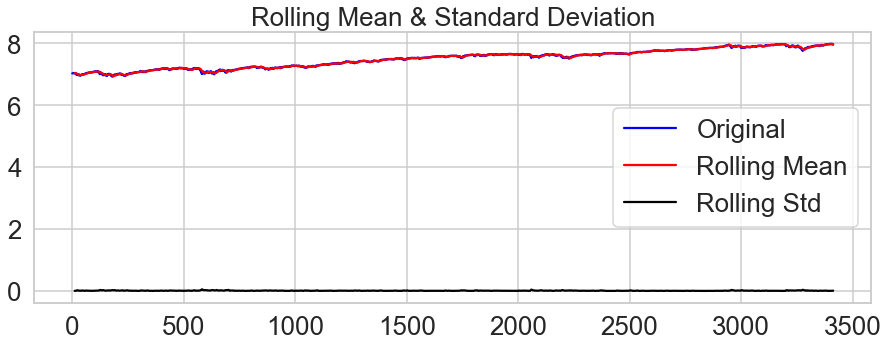

In [14]:
sp_close_arima_df = sp_close_arima
log_series = np.log(sp_close_arima_df.Close)

ad_fuller_test(log_series)
plot_rolling_stats(log_series)

The series is non-stationary even after being log-transformed. 

### Log Differencing

"As discussed in the key concepts", differencing a series helps in achieving stationarity. 

In [15]:
# Using log series with a shift to make it stationary
log_series_shift = log_series - log_series.shift()
log_series_shift = log_series_shift[~np.isnan(log_series_shift)]

Test Statistic                  -24.236899
p-value                           0.000000
#Lags Used                        6.000000
Number of Observations Used    3406.000000
Critical Value (1%)              -3.432271
Critical Value (5%)              -2.862389
Critical Value (10%)             -2.567222
dtype: float64


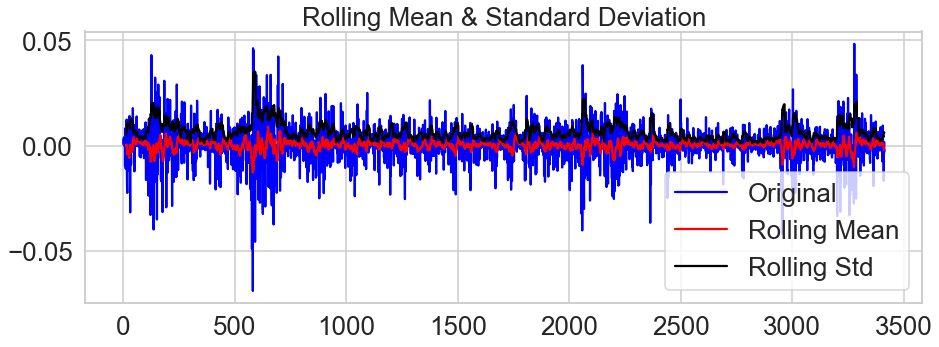

In [16]:
ad_fuller_test(log_series_shift)
plot_rolling_stats(log_series_shift)

The test statistic at -24.23 is lower than even 1% critical value, thus we reject the null hypothesis for AD Fuller test. 
We could use a log differenced series for ARIMA modeling of the SP500 data.

### ACF/ PACF

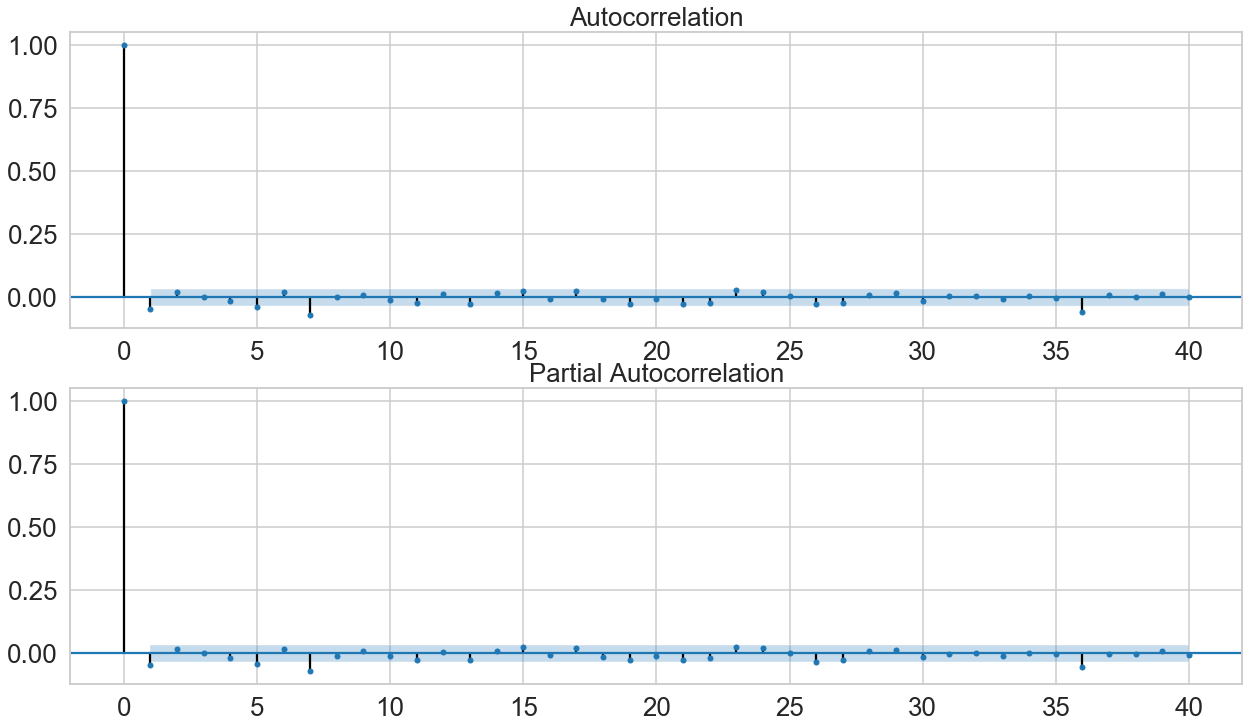

In [17]:
plot_acf_pacf(log_series_shift)

## 5.ARIMA

In [23]:
sp_close_arima_df['log_series'] = log_series
sp_close_arima_df['log_series_shift'] = log_series_shift

In [26]:
sp_close_arima_df.head(5)
sp_close_arima_df = sp_close_arima_df.set_index('index')

In [20]:
from arima_utils import plot_acf_pacf, arima_gridsearch_cv

********************
Iteration 1 of 5
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 2

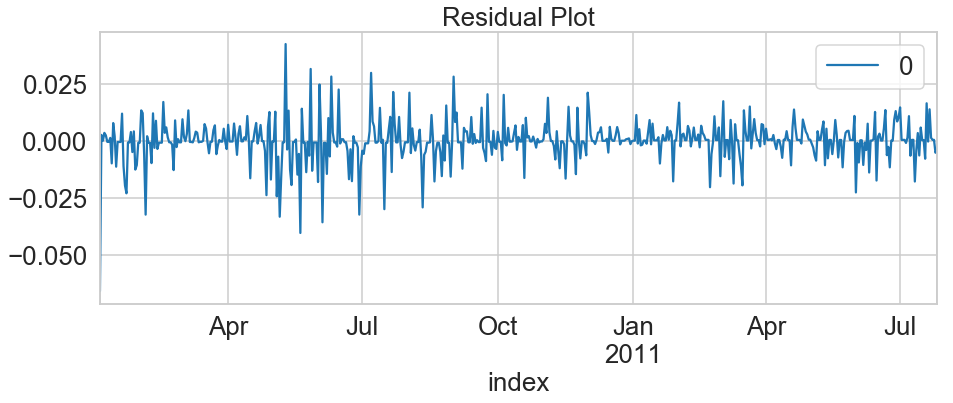

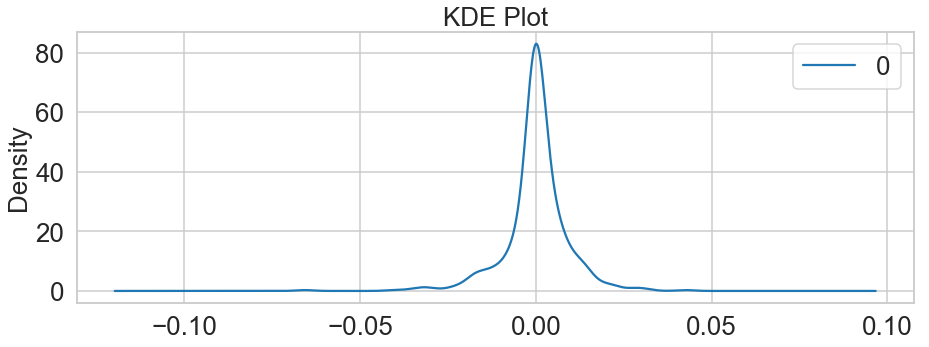

                0
count  569.000000
mean     0.000115
std      0.009004
min     -0.065706
25%     -0.001311
50%      0.000139
75%      0.003595
max      0.042558


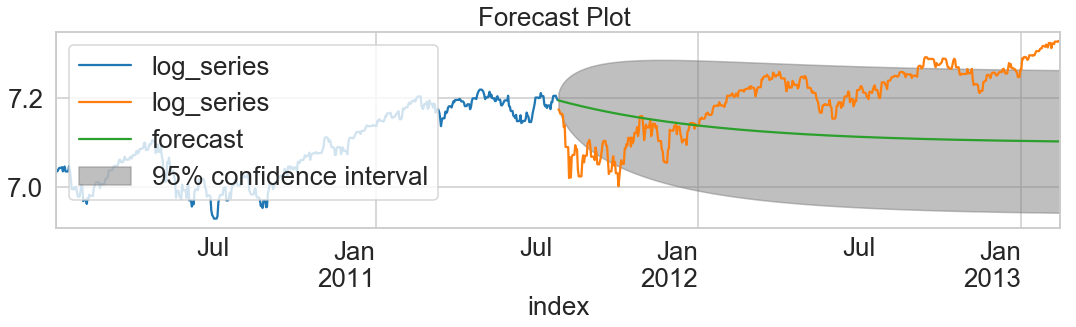

ValueError: Cannot add integral value to Timestamp without freq.

In [27]:
results_dict = arima_gridsearch_cv(sp_close_arima_df.log_series,cv_splits=5)

## References:

1. https://anomaly.io/seasonal-trend-decomposition-in-r/
2. https://www.investopedia.com/articles/active-trading/11/four-types-of-active-traders.asp
3. https://nbviewer.jupyter.org/github/jdwittenauer/ipython-notebooks/blob/master/notebooks/misc/TimeSeriesStockAnalysis.ipynb
4. http://people.duke.edu/~rnau/411home.htm
5. https://machinelearningmastery.com/time-series-data-stationary-python/